<a href="https://colab.research.google.com/github/hmkhalif/PDS-Project/blob/main/PDSFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicting Movie Ratings from RottenTomatoes**
***Haya Al-Khalifa and Aisha Al-Subaie***

###<font color=green> **Introduction** </font>

#### **Question:** *Can we predict the ratings of movie's based on features like a movies summary, genre, cast, and other relevant factors? What factors have the most significant influence on movie ratings?*



Our primary motivation behind this project is to explore whether we can predict the ratings of movies based on various features. We're curious if factors like the movie summary, genre, and cast have a say in how a movie gets rated. Do some factors matter more than others? We'll start by scraping movies from the Rotten Tomatoes website, a review-aggregation website for film and television, cleaning and processing it. Following that, we'll conduct an in-depth exploration of the data to uncover patterns and correlations. After that, we'll deploy a Random Forest Regressor to model Tomatometer Scores. Our goal is to answer whether it's feasible to predict movie ratings and identify the key factors influencing them.

###<font color=green> **Data Collection** </font>

In this data collection process, we started by scraping movie titles from Rotten Tomatoes using the following function. It iterates through various genres, constructing URLs for each genre and extracting movie titles. We encountered limitations imposed by Rotten Tomatoes on the number of requests we could make. So we capped the requests to a maximum of 5 pages per genre. Duplicate movies were removed to ensure uniqueness in our data and prevent redundancy in movies.



In [ ]:
import requests
from bs4 import BeautifulSoup

def scrape_movies(url, max_pages=None):
    movie_titles = []

    # Loop through pages
    for page in range(1, max_pages + 1) if max_pages else iter(int, 1):
        # Construct the URL for the current page
        page_url = f"{url}?page={page}"

        # Send a GET request to the current URL
        response = requests.get(page_url)

        # Check if the request was successful
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')

            # Find all elements with the class 'p--small' inside the 'span' tag
            title_elements = soup.find_all('span', class_='p--small', attrs={'data-qa': 'discovery-media-list-item-title'})

            # Extract and append the movie titles
            movie_titles.extend(title_element.get_text(strip=True) for title_element in title_elements)
        else:
            print(f"Failed to retrieve page {page}. Status code: {response.status_code}")
            break

    return movie_titles

# List of genres
genres = [
    "action", "adventure", "animation", "anime",
    "biography", "comedy", "crime", "documentary", "drama",
    "entertainment", "fantasy", "history", "horror", "music",
    "reality", "romance", "travel", "war", "stand_up", "sports",
    "soap", "variety", "short", "sci_fi", "western",
    "mystery_and_thriller", "nature", "news", "faith_and_spirituality",
    "game_show", "holiday", "special_interest"
]

# Set the maximum number of pages to scrape (rottentomatoes only allows 5 max)
max_pages = 5

# Scrape movies from multiple URLs
movie_titles = []
for genre in genres:
    url = f"https://www.rottentomatoes.com/browse/movies_at_home/genres:{genre}"
    movie_titles.extend(scrape_movies(url, max_pages))

# Remove duplicates
unique_movie_titles = list(set(movie_titles))


We saved the resulting movie titles in a text file named **`scraped_movies.txt`** for future reference. This helped us avoid sending RottenTomatoes many requests since we experienced some delays due to the website's security measures.



In [ ]:
movie_titles=list(set(movie_titles))

file_path = "scraped_movies.txt"

# Writing the movie titles to a text file without indices
with open(file_path, 'w') as file:
    for title in movie_titles:
        file.write(f"{title}\n")

In the following step, we gathered detailed information about each movie using the movie titles we collected earlier. The **`scrape_movie_url`** function cleaned the titles for constructing URLs and then sent requests to Rotten Tomatoes to fetch url for each movie. The loop iterated through the movie titles, calling the scraping function, and stored the successfully retrieved titles in the successful_movie_titles list, which we saved in a text file named **`successful_movie_titles.txt`** for future reference.

The reason we broke down this step before gathering a movie's information is because some movies weren't directly associated with the clean urls. For instance, movies with duplicate names were often associated with the year in the url to help differentiate between the different movies. Due to time constraints, we decided to drop these movies from our list, since it would require human interference to fix.

In [ ]:
import requests
from bs4 import BeautifulSoup
import re

# Function to clean the title for constructing the URL
def clean_title_for_url(title):
    cleaned_title = re.sub(r'[^a-zA-Z0-9]+', '_', title).lower()
    return cleaned_title

# Function to scrape movie info
def scrape_movie_url(title):
    cleaned_title = clean_title_for_url(title)
    url = f"https://www.rottentomatoes.com/m/{cleaned_title}"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        return title
    else:
        print(f"Failed to retrieve the page for {title}. Status code: {response.status_code}")
        return None

# List to store successful movie titles
successful_movie_titles = []

# Loop through movie titles to scrape info
for title in movie_titles:
    scraped_title = scrape_movie_info(title)
    if scraped_title:
        successful_movie_titles.append(scraped_title)

# Display successful movie titles
for title in successful_movie_titles:
    print(title)

In [ ]:
file_path = "successful_movie_titles.txt"

# Writing the movie titles to a text file
with open(file_path, 'w') as file:
    for title in successful_movie_titles:
        file.write(f"{title}\n")

The **`clean_title_for_url`** function removed special characters and spaces, converting the titles to lowercase for URL construction. The scrape_movie_info function, for each movie title, constructed the URL, sent a GET request to Rotten Tomatoes, and parsed the HTML content. It extracted diverse movie details such as synopsis, rating, genre, original language, director, producer, writer, runtime, distributor, production company, sound mix, Tomatometer score and state, Audience score, critic reviews counts, and the count of "where-to-watch-meta" tags. The script looped through the successfully retrieved movie titles, collected the extracted information into a dictionary (movies_info), and wrote it to a text file named **'movie_info.txt'** for subsequent analysis.

In [ ]:
import re
import requests
from bs4 import BeautifulSoup

def clean_title_for_url(title):
    # Remove special characters and spaces, then convert to lowercase
    cleaned_title = re.sub(r'[^a-zA-Z0-9]+', '_', title).lower()
    return cleaned_title

def scrape_movie_info(title):
    # Clean the title for constructing the URL
    cleaned_title = clean_title_for_url(title)

    # Construct the URL for the current movie
    url = f"https://www.rottentomatoes.com/m/{cleaned_title}"

    # Send a GET request to the movie URL
    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract movie info
        movie_synopsis = soup.find('p', attrs={'data-qa': 'movie-info-synopsis'})
        rating = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Rating:')
        genre = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Genre:')
        original_language = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Original Language:')
        director = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Director:')
        producer = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Producer:')
        writer = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Writer:')
        runtime = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Runtime:')
        distributor = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Distributor:')
        production_co = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Production Co:')
        sound_mix = soup.find('b', attrs={'data-qa': 'movie-info-item-label'}, string='Sound Mix:')
        tomatometer = soup.find('span', class_='percentage', attrs={'data-qa': 'tomatometer'})

        # Extract tomatometer score and state
        tomatometer_score = soup.find('score-board-deprecated', attrs={'mediatype': 'movie'}).get('tomatometerscore')
        tomatometer_state = soup.find('score-board-deprecated', attrs={'mediatype': 'movie'}).get('tomatometerstate')
        audience_score = soup.find('score-board-deprecated', attrs={'mediatype': 'movie'}).get('audiencescore')

        # Extract critic reviews counts
        all_critics = soup.find('a', attrs={'data-qa': 'critic-reviews-all-filter'})
        top_critics = soup.find('a', attrs={'data-qa': 'critic-reviews-top-filter'})
        fresh_reviews = soup.find('a', attrs={'data-qa': 'critic-reviews-fresh-filter'})
        rotten_reviews_tag = soup.find('a', attrs={'data-qa': 'critic-reviews-rotten-filter'})

        # Check if each tag is not None before accessing attributes
        all_critics = all_critics.text.split(' ')[-1].replace('(', '').replace(')', '') if all_critics else None
        top_critics = top_critics.text.split(' ')[-1].replace('(', '').replace(')', '') if top_critics else None
        fresh_reviews = fresh_reviews.text.split(' ')[-1].replace('(', '').replace(')', '') if fresh_reviews else None
        rotten_reviews = rotten_reviews_tag.text.split(' ')[-1].replace('(', '').replace(')', '') if rotten_reviews_tag else None

         # Count <where-to-watch-meta> tags
        where_to_watch_meta_tags = soup.find_all('where-to-watch-meta')
        tag_count = len(where_to_watch_meta_tags)

        # Structure the movie info in a dictionary
        movie_info = {
            'Synopsis': movie_synopsis.get_text(strip=True) if movie_synopsis else None,
            'Rating': rating.find_next('span').get_text(strip=True) if rating else None,
            'Genre': genre.find_next('span', class_='genre').get_text(strip=True) if genre else None,
            'Original Language': original_language.find_next('span').get_text(strip=True) if original_language else None,
            'Director': director.find_next('span').get_text(strip=True) if director else None,
            'Producer': producer.find_next('span').get_text(strip=True) if producer else None,
            'Writer': writer.find_next('span').get_text(strip=True) if writer else None,
            'Runtime': runtime.find_next('span').get_text(strip=True) if runtime else None,
            'Distributor': distributor.find_next('span').get_text(strip=True) if distributor else None,
            'Production Co': production_co.find_next('span').get_text(strip=True) if production_co else None,
            'Sound Mix': sound_mix.find_next('span').get_text(strip=True) if sound_mix else None,
            'Tomatometer': tomatometer.text if tomatometer else None,
            'Tomatometer Score': tomatometer_score,
            'Tomatometer State': tomatometer_state,
            'Audience Score': audience_score,
            'Num of All Critics Reviews': all_critics,
            'Num of Top Critics Reviews': top_critics,
            'Num of Fresh Reviews': fresh_reviews,
            'Num of Rotten Reviews': rotten_reviews,
            'Where to Watch Tags Count': tag_count
        }

        return title, movie_info
    else:
        print(f"Failed to retrieve the page for {title}. Status code: {response.status_code}")
        return None

# Read movie titles from the text file
with open('successful_movie_titles.txt', 'r') as file:
    movie_titles = [line.strip() for line in file]

# Collect movie info in a dictionary
movies_info = {}
for title in movie_titles:
    movie_info = scrape_movie_info(title)
    if movie_info:
        movies_info[title] = movie_info[1]

# Write movie_info to a text file
with open('movie_info.txt', 'w') as file:
    for title, info in movies_info.items():
        file.write(f"{title}:\n{info}\n\n")


###<font color=green> **Data Processing and Cleaning** </font>

Now, let's move on to the next step: **data processing and cleaning**. After parsing the file content into a dictionary of dictionaries **`movie_dict`**, we can perform various operations to handle any inconsistencies or errors in the data and prepare it for further analysis.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Open the uploaded file and read its content
file_path = '/content/drive/MyDrive/ColabNotebooks/movie_info.txt'

with open(file_path, 'r') as file:
    content = file.readlines()

# Parse the content into a dictionary of dictionaries
movie_dict = {}
current_key = None
for line in content:
    if line.strip() and not line.startswith("{") and not line.startswith("}"):
        current_key = line.strip().rstrip(":")
        movie_dict[current_key] = {}
    elif line.strip().startswith("{"):
        movie_dict[current_key] = eval(line)


Mounted at /content/drive


In [ ]:
import pandas as pd
# Convert the dictionary of dictionaries into a pandas DataFrame
movies_df = pd.DataFrame.from_dict(movie_dict, orient='index')
movies_df.head(3)  # Display the first few rows of the DataFrame

,Synopsis,Rating,Genre,Original Language,Director,Producer,Writer,Runtime,Distributor,Production Co,Sound Mix,Tomatometer,Tomatometer Score,Tomatometer State,Audience Score,Num of All Critics Reviews,Num of Top Critics Reviews,Num of Fresh Reviews,Num of Rotten Reviews,Where to Watch Tags Count
Grave of the Fireflies,A teenager (J. Robert Spencer) is charged with...,None,"Drama, \n \n ...",Japanese,Isao Takahata,Toru Hara,Isao Takahata,1h 28m,None,None,None,None,100,certified-fresh,95,45,12,45,None,2
Silverado,Rambling man Emmett (Scott Glenn) assembles a ...,PG-13,Western,English,Lawrence Kasdan,Lawrence Kasdan,"Lawrence Kasdan,Mark Kasdan",2h 12m,"Criterion Collection, \n ...",Columbia Pictures Corporation,"Surround, Stereo",None,78,fresh,80,36,10,28,8,4
Milli Vanilli,The bizarre untold truth behind the greatest c...,None,"Documentary, \n \n ...",English,Luke Korem,"Luke Korem,Bradley Jackson",None,1h 46m,Paramount+,"MRC, \n \n ...",None,None,100,fresh,91,25,10,25,None,1


In [ ]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1696 entries, Grave of the Fireflies to Jerry Seinfeld: 23 Hours to Kill
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Synopsis                    1696 non-null   object
 1   Rating                      1012 non-null   object
 2   Genre                       1686 non-null   object
 3   Original Language           1652 non-null   object
 4   Director                    1665 non-null   object
 5   Producer                    1315 non-null   object
 6   Writer                      1381 non-null   object
 7   Runtime                     1657 non-null   object
 8   Distributor                 1064 non-null   object
 9   Production Co               1290 non-null   object
 10  Sound Mix                   642 non-null    object
 11  Tomatometer                 0 non-null      object
 12  Tomatometer Score           1696 non-null   object
 13  Toma

After converting our data into a Pandas DataFrame, we noticed the presence of null values in several columns, indicating that data cleaning is necessary for future analysis (seen from above).

Specific to the movies information, RottenTomatoes lacked many details specifically in the Rating, Producer, Writer, Distributor, Production Co and Sound Mix areas. Due to RottenTomatoes limited webscraping abilities and these values being categorical, we didn't feel it was appropriate to fill them in with missing values. Therefore, we made the decision to drop these columns from our analysis, again due to time constraint. In the future, if we had the possiblity to webscrape more movies, we would've chosen not to drop these columns.

In [ ]:
# Creating a copy of the original DataFrame
movies_final = movies_df.copy()

# Dropping specified columns
columns_to_drop = ['Rating', 'Producer', 'Writer', 'Distributor', 'Production Co', 'Sound Mix', 'Tomatometer']
movies_final.drop(columns=columns_to_drop, inplace=True)

Dealing with review count (integers), when we webscraped, if not found we set it to None. Therefore, Nones are equivalent to 0 in this case since no movie reviews were found.

In [ ]:
# Replacing nulls with 0s in specified columns
columns_to_fill_zero = [
    'Num of All Critics Reviews',
    'Num of Top Critics Reviews',
    'Num of Fresh Reviews',
    'Num of Rotten Reviews'
]

for column in columns_to_fill_zero:
    movies_final[column] = movies_final[column].fillna(0).astype(int)

# Dropping rows with any null values in the DataFrame
movies_final = movies_final.dropna()

# Split genres and take the first one, also remove leading/trailing whitespaces
movies_final['Genre'] = movies_final['Genre'].str.split(',').str[0].str.strip()

<ipython-input-10-1dfbc1e2d105>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_final['Genre'] = movies_final['Genre'].str.split(',').str[0].str.strip()


Part of our preprocessing was also making data in types that were possible to deal with in our future analysis. We added the conversion function below to convert movie time from the RottenTomato format (eg, 1h 30 m) into the total minutes.

In [ ]:
# conversion function
def runtime_to_minutes(runtime_str):
    if pd.isnull(runtime_str):
        return None
    parts = runtime_str.split(' ')
    minutes = 0
    for part in parts:
        if 'h' in part:
            minutes += int(part.replace('h', '')) * 60
        elif 'm' in part:
            minutes += int(part.replace('m', ''))
    return minutes

movies_final['Runtime Minutes'] = movies_final['Runtime'].apply(runtime_to_minutes)

# Displaying the DataFrame information to confirm the changes
movies_final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1597 entries, Grave of the Fireflies to Jerry Seinfeld: 23 Hours to Kill
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Synopsis                    1597 non-null   object
 1   Genre                       1597 non-null   object
 2   Original Language           1597 non-null   object
 3   Director                    1597 non-null   object
 4   Runtime                     1597 non-null   object
 5   Tomatometer Score           1597 non-null   object
 6   Tomatometer State           1597 non-null   object
 7   Audience Score              1597 non-null   object
 8   Num of All Critics Reviews  1597 non-null   int64 
 9   Num of Top Critics Reviews  1597 non-null   int64 
 10  Num of Fresh Reviews        1597 non-null   int64 
 11  Num of Rotten Reviews       1597 non-null   int64 
 12  Where to Watch Tags Count   1597 non-null   int64 
 13  Runt

Lastly, although the dataframe info from above shows non-nulls, we realized we need to convert scores into numeric values. This exposed that we still have issues within our data.

In [ ]:
# Check the data types of 'Tomatometer Score' and 'Audience Score'
print(movies_final[['Tomatometer Score', 'Audience Score']].dtypes)

# Convert the columns to numeric
movies_final['Tomatometer Score'] = pd.to_numeric(movies_final['Tomatometer Score'], errors='coerce')
movies_final['Audience Score'] = pd.to_numeric(movies_final['Audience Score'], errors='coerce')

# Check the data types again
print(movies_final[['Tomatometer Score', 'Audience Score']].dtypes)


Tomatometer Score    object
Audience Score       object
dtype: object
Tomatometer Score    float64
Audience Score       float64
dtype: object


In [ ]:
print(movies_final["Tomatometer Score"].isnull().sum())

406


In [ ]:
# Filter out rows where 'Tomatometer Score' is null
movies_final = movies_final[movies_final["Tomatometer Score"].notnull()]
movies_final = movies_final[movies_final["Audience Score"].notnull()]

movies_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1176 entries, Grave of the Fireflies to Jerry Seinfeld: 23 Hours to Kill
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Synopsis                    1176 non-null   object 
 1   Genre                       1176 non-null   object 
 2   Original Language           1176 non-null   object 
 3   Director                    1176 non-null   object 
 4   Runtime                     1176 non-null   object 
 5   Tomatometer Score           1176 non-null   float64
 6   Tomatometer State           1176 non-null   object 
 7   Audience Score              1176 non-null   float64
 8   Num of All Critics Reviews  1176 non-null   int64  
 9   Num of Top Critics Reviews  1176 non-null   int64  
 10  Num of Fresh Reviews        1176 non-null   int64  
 11  Num of Rotten Reviews       1176 non-null   int64  
 12  Where to Watch Tags Count   1176 non-null   in

###<font color=green> **Data Visualization** </font>

Now that we processed our data and cleaned it, we're ready to visualize our data. In the context of movie variables, visualizing data can provide us with actionable insights and patterns that can be used to predict future trends and successes in the film industry.

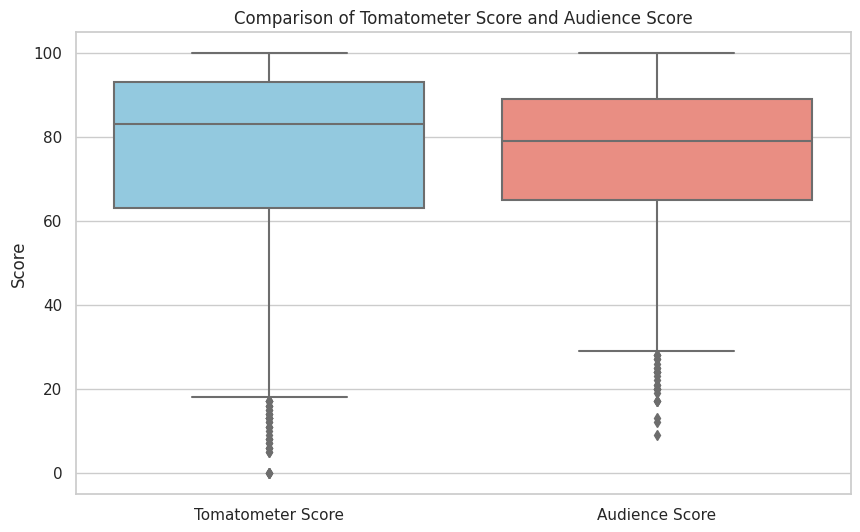

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# Create a boxplot for 'Tomatometer Score' and 'Audience Score' in a single grid
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_final[['Tomatometer Score', 'Audience Score']].astype(float), palette=['skyblue', 'salmon'])
plt.title('Comparison of Tomatometer Score and Audience Score')
plt.ylabel('Score')
plt.show()

 The boxplot above compares the distribution of the 'Tomatometer Score' (critics' ratings) with the 'Audience Score' for a set of movies. The median for both scores appears to be roughly in the same range, with tomatometer a little higher. While the median ratings are similar, the critics have a broader range of opinions about movies, as indicated by the wider interquartile range.


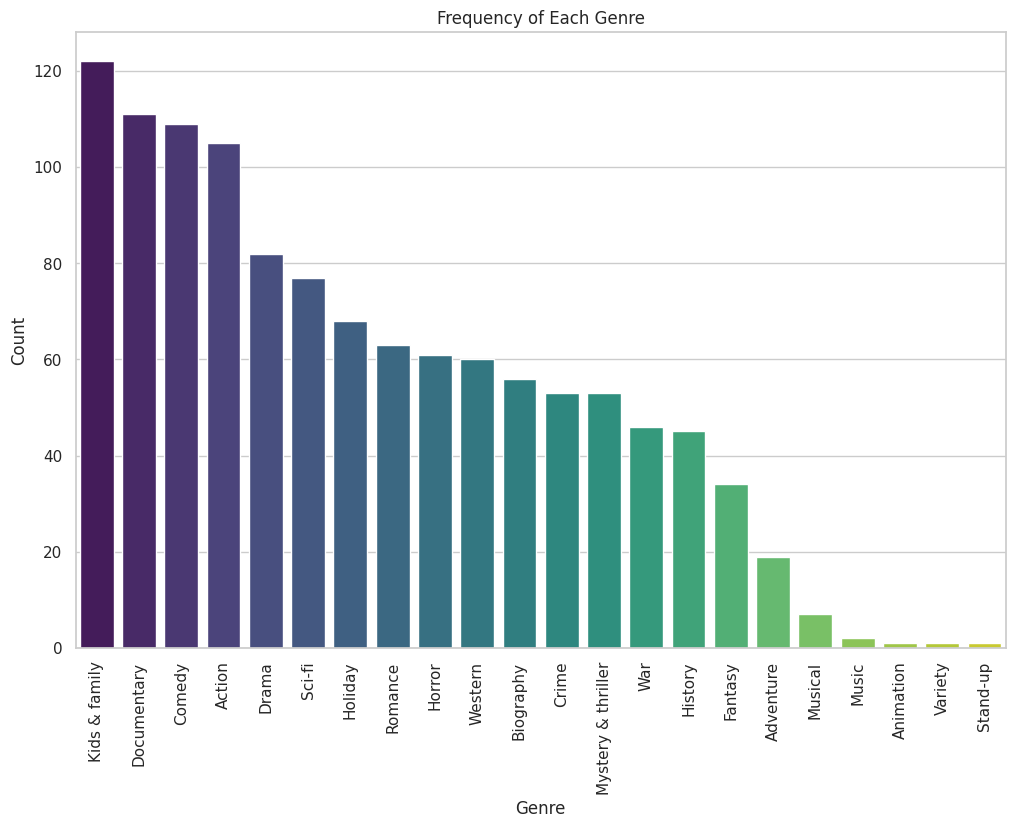

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each genre
genre_counts = movies_final['Genre'].value_counts()

# Plot a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=genre_counts.index, y=genre_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Frequency of Each Genre')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

The bar chart above visually represents the frequency of each genre within the dataset, providing insights into the distribution of movie genres. It shows that the "Kids & Family" genre has the highest occurrence, indicating a significant representation of movies tailored for a younger audience. On the other hand, genres like "Stand-Up" have the lowest frequency, suggesting fewer movies in this category.

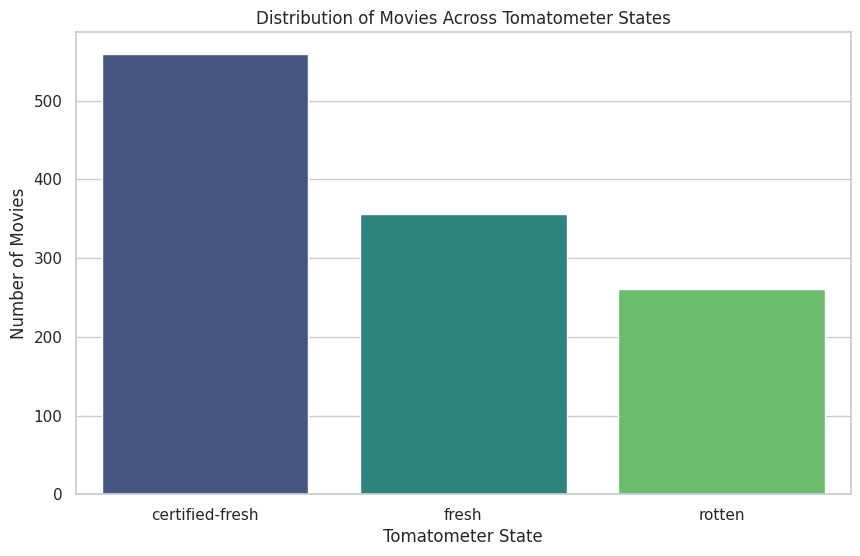

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each Tomatometer State
tomatometer_state_counts = movies_final['Tomatometer State'].value_counts()

# Plot the distribution using a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=tomatometer_state_counts.index, y=tomatometer_state_counts.values, palette='viridis')
plt.title('Distribution of Movies Across Tomatometer States')
plt.xlabel('Tomatometer State')
plt.ylabel('Number of Movies')
plt.show()


The bar chart above visualizes the distribution of movies across different Tomatometer states, categorizing them into "Certified Fresh," "Fresh," and "Rotten."

  **1) Certified Fresh (More than 500 movies):** This category has the highest count, suggesting a substantial number of movies that received highly positive reviews from critics and achieved a Tomatometer score that qualifies them as "Certified Fresh."

  2) **Fresh:** The middle section represents movies that garnered positive reviews but didn't meet the stringent criteria for "Certified Fresh." These movies fall within the broader "Fresh" category, showcasing a moderate count.

  3) **Rotten:** This category has the fewest movies, indicating films that received predominantly negative reviews and have a Tomatometer score categorized as "Rotten."



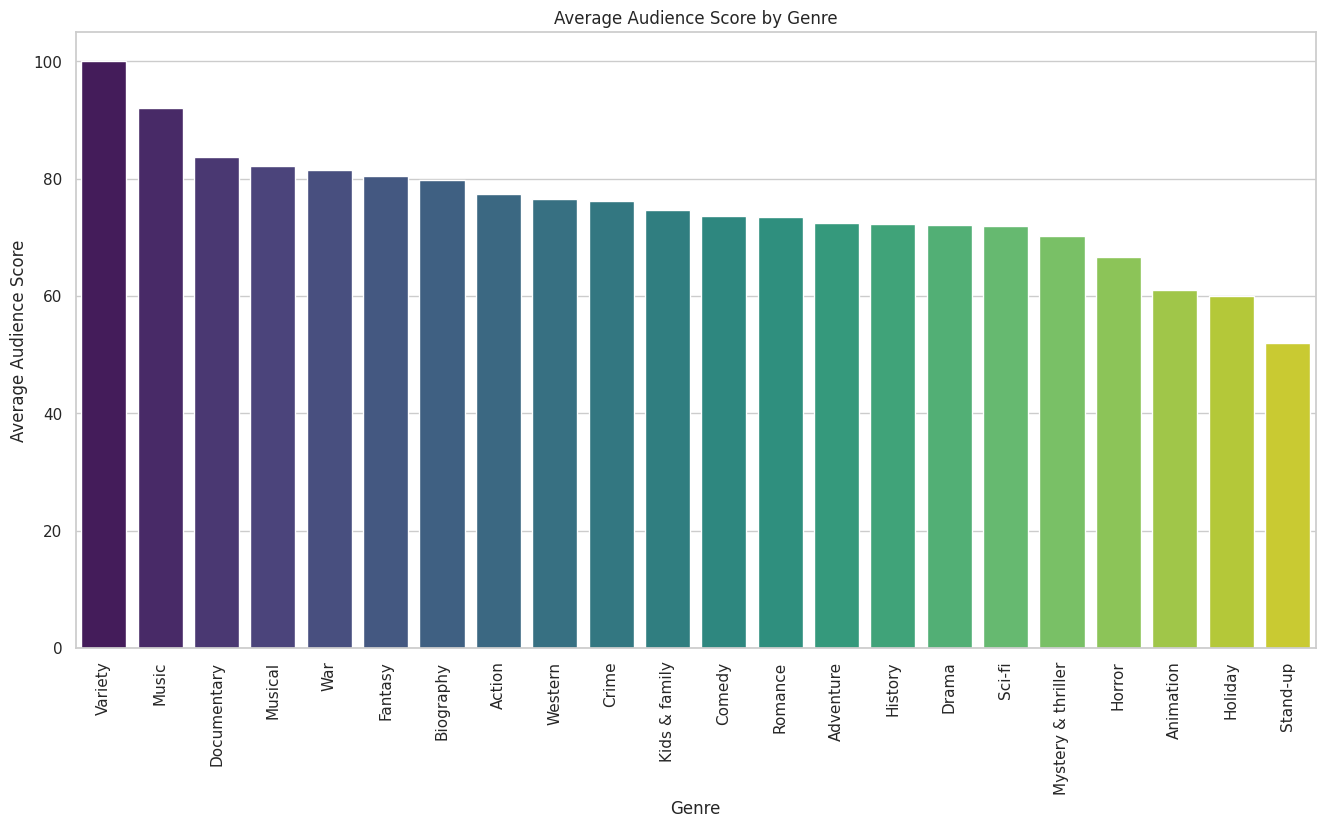

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the average audience score for each genre
average_scores_by_genre = movies_final.groupby('Genre')['Audience Score'].mean().sort_values(ascending=False)

# Set the size of the plot
plt.figure(figsize=(16, 8))

# Create a bar plot
sns.barplot(x=average_scores_by_genre.index, y=average_scores_by_genre, palette='viridis')

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Set plot title and labels
plt.title('Average Audience Score by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Audience Score')

# Show the plot
plt.show()


The bar chart above visualizes the average audience scores by genre, and there’s clearly a significant difference per genre. With variety having the highest average and stand up genres being the lowest. This allows us to understand which genres are currently resonating with audiences. However, it's important to consider that we scraped a higher count of movies in some genres more than others, which might have influence on the overall audience score.


#### **Exploring Impact of Critics**

Tomatometer Score is taken from professional critic reviews, while Audience Score is from users of Rotten Tomato. The exploration of whether audiences are influenced by critics is an important aspect of understanding the dynamics of film reception. We wanted to investigate whether the opinions of professional critics have a bearing on the opinions of the general audience. Often, people opinions' are influenced by professionals and experts so we wanted to see how close Critic and Audience scores were. By examining the correlation between these two metrics, we seek to quantify the potential impact of critical acclaim on audience judgment.

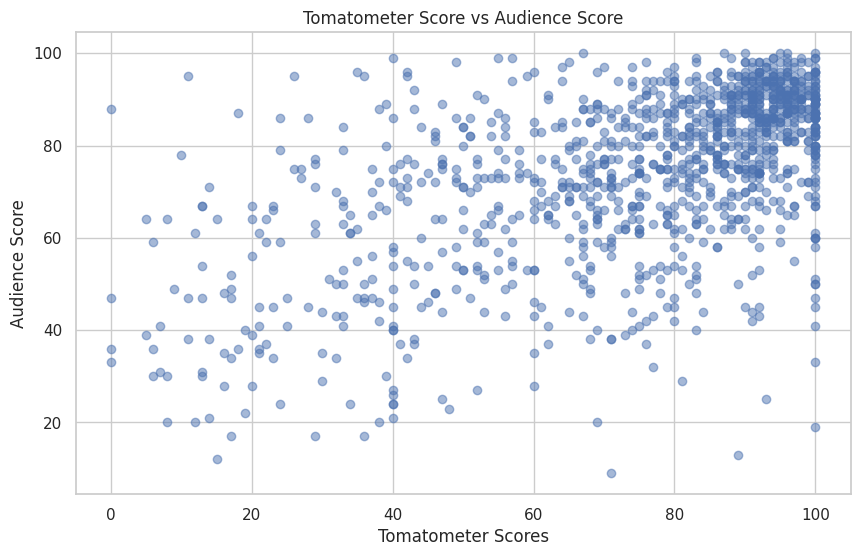

The correlation coefficient between the tomatometer score and audience score is: 0.5615346117463461


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Correlation Analysis
correlation = movies_final['Tomatometer Score'].corr(movies_final['Audience Score'])

# Visual Representation
plt.figure(figsize=(10, 6))
plt.scatter(movies_final['Tomatometer Score'], movies_final['Audience Score'], alpha=0.5)
plt.title('Tomatometer Score vs Audience Score')
plt.xlabel('Tomatometer Scores')
plt.ylabel('Audience Score')
plt.grid(True)
plt.show()

# Output the correlation
print(f"The correlation coefficient between the tomatometer score and audience score is: {correlation}")


The scatter plot from above shows the relationship between Tomatometer scores and Audience scores for movies.
- The distribution indicates a moderate positive correlation between the two variables. As Tomatometer scores increase, generally Audience scores increases too.
- Points are concentrated more densely at higher scores for both Tomatometer and Audience ratings, suggesting that movies which are well-received by critics also tend to be well-received by audiences (top right quadrant).
- There is notable variability, especially in the middle range of Tomatometer scores where Audience scores vary widely. So although there is some alignment with higher scores, audience opinions are not entirely predictable based on critic scores alone.

The correlation coefficient of 0.56 is a statistical measure that confirms the visual trend observed in the scatter plot. It is not so high as to suggest a direct causal relationship, but it is significant enough to imply that there is a notable association between critic and audience score, but critic reviews are not the sole factor in determining how audiences rate a movie.

By studying critics weighting on audiences, the movie industry can craft strategies that use critical acclaim to their advantage. For instance, high critic scores can be used in marketing materials to build hype and credibility towards audiences. It is also important to work with critics in order to generate more reviews, which increases the visibility of the critic scores.

#### **Director Variable**

We wanted to explore if a director's work had any influence on a movie's Tomatometer and Audience Score. To do this, we wanted to consider directors with significant movie contributions (multiple of their work) and avoid drawing meaningful conclusions from directors with fewer films since it would skew or lead to unreliable results.

In [ ]:
# Group by Director and calculate the mean of Tomatometer and Audience Scores
director_ratings = movies_final.groupby('Director')[['Tomatometer Score', 'Audience Score']].mean()

# Counting the number of movies per director
movie_counts = movies_final['Director'].value_counts()

# Merge this count with the director_ratings DataFrame
director_ratings_with_count = director_ratings.merge(movie_counts.rename('Movie Count'), left_index=True, right_index=True)

# Filter out directors with very few movies
filtered_directors = director_ratings_with_count[director_ratings_with_count['Movie Count'] >= 4]

# Sort by 'Tomatometer Score'
top_directors = filtered_directors.sort_values(by='Tomatometer Score', ascending=False)

# Display the top directors with their average ratings and movie counts
top_directors.head(10)

,Tomatometer Score,Audience Score,Movie Count
Brad Bird,95.500000,84.000000,4
Hayao Miyazaki,94.166667,90.833333,6
Sergio Leone,92.800000,92.400000,5
David O. Russell,92.250000,81.500000,4
Isao Takahata,91.000000,84.250000,4
"Anthony Russo,Joe Russo",90.000000,90.750000,4
Martin Scorsese,89.666667,89.166667,6
James Gunn,88.600000,87.000000,5
James Cameron,87.200000,85.400000,5
David Fincher,86.428571,84.428571,7


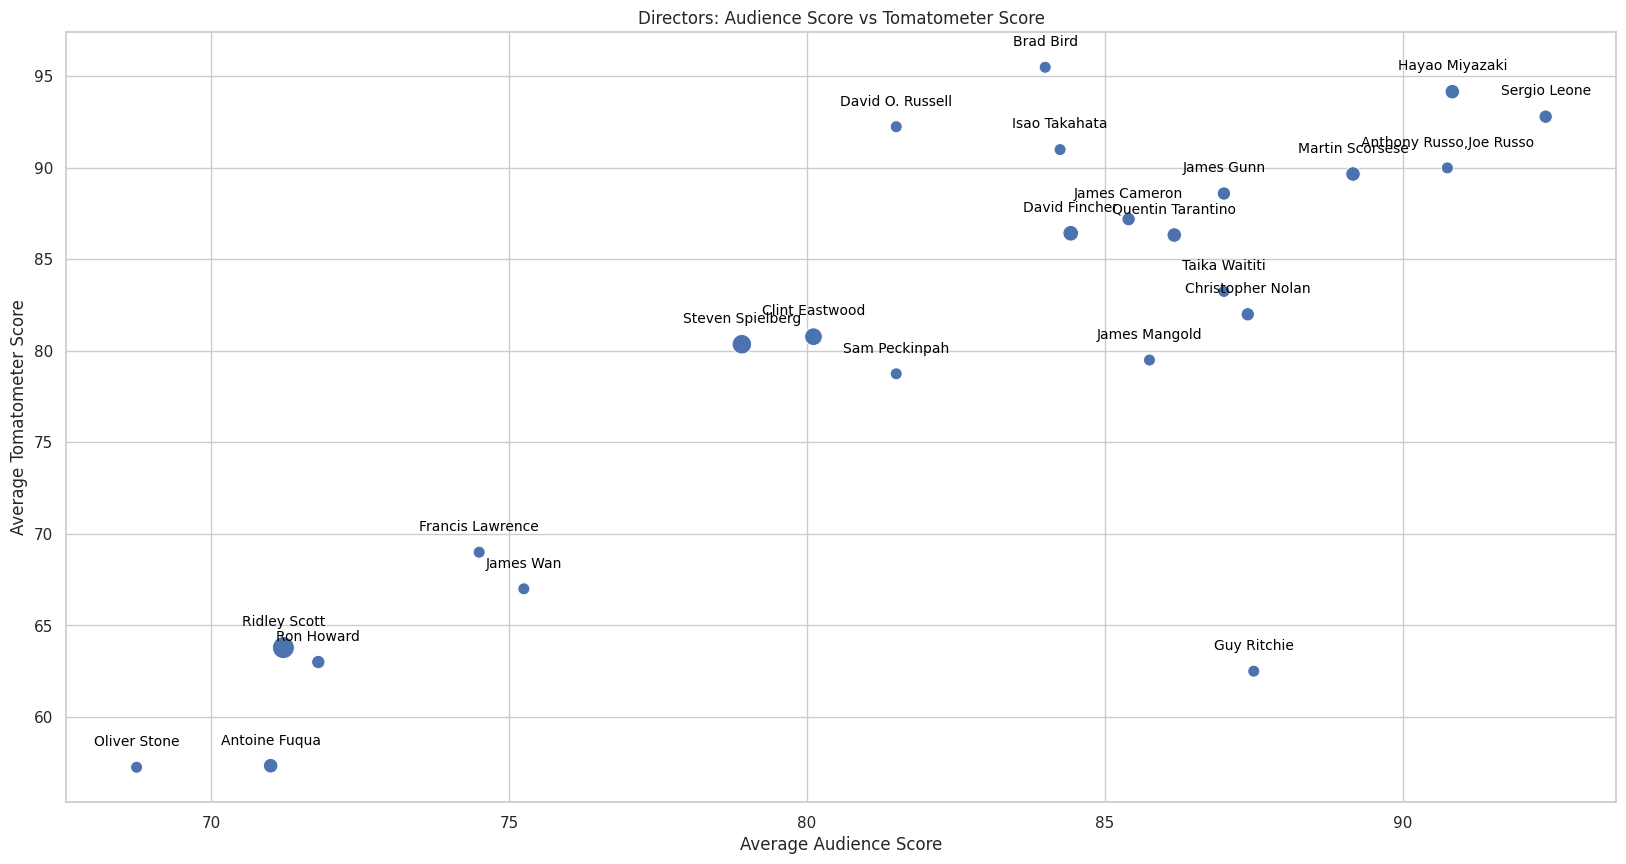

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 10))

# Create a scatter plot with Audience Score on the x-axis and Tomatometer Score on the y-axis
# Adjust the size of each point to represent the number of movies
sns.scatterplot(data=top_directors, x='Audience Score', y='Tomatometer Score', size='Movie Count', sizes=(75, 250), legend=False)

# Annotate each point with the director's name
for index, row in top_directors.iterrows():
    # Add an offset to y-coordinate for annotation to avoid overlap with the dot
    y_offset = 1  # Adjust this value as needed for your plot
    plt.text(row['Audience Score'], row['Tomatometer Score'] + y_offset, index,
             horizontalalignment='center', verticalalignment='bottom',
             size='small', color='black')

# Enhancing the plot
plt.title('Directors: Audience Score vs Tomatometer Score')
plt.xlabel('Average Audience Score')
plt.ylabel('Average Tomatometer Score')
plt.grid(True)

# Show plot
plt.show()

The graph above compares the average audience score to the average Tomatometer score of various film directors.

1. **High Audience and Tomatometer Scores**: Directors located in the top right quadrant indicate high scores from both critics (Tomatometer) and audiences such as Hayao Miyazaki and Christopher Nolan. This suggests a strong positive reception for their work from both critics and the general public.

2. **Critical vs. Audience Reception**: Some directors have high average Tomatometer scores but slightly lower audience scores, indicating that while critics rate their films highly, audiences are slightly less enthusiastic. Conversely, directors that have higher audience scores relative to their Tomatometer scores, suggesting that audiences may appreciate their films more than critics do.

3. **Lower Scores in Both Metrics**: Some directors have lower average scores from both audiences and critics, showing that both groups are less favorable towards their films compared to those of other directors on the plot.

Visualization is helpful for stakeholders in the film industry, such as producers, marketers, and distributors, to understand the market's reception to different directors' work. Although we cannot infer causation since many factors can impact a movie's ratings, it could help a movie do well with a director that is well-received critically and popularly,

#### **Movie Availability**

Rotten Tomato features a section of "Where to Watch" for each movie, a way for users to find out where they can legally stream or purchase a movie. We wanted to explore if the accessibility of the movie can have an impact on its score. We initally thought that films that are easily accessible are more likely to be watched and rated by a larger audience, which can influence the overall audience score.

In [ ]:
correlation = movies_final['Where to Watch Tags Count'].corr(movies_final['Audience Score'])
print(f"The correlation between 'Where to Watch Tags Count' and 'Audience Score' is: {correlation}")

The correlation between 'Where to Watch Tags Count' and 'Audience Score' is: 0.07977915625354405


The correlation coefficient between 'Where to Watch Tags Count' and 'Audience Score' is approximately 0.080, which indicates a very weak positive relationship between these two variables. The number of platforms a movie is available on is just one of many factors that could contribute to its audience score, so we cannot at this stage imply causation from movie availability alone.

Also, visualizing this data (seen below), shows us that the audience scores are relatively consistent across different 'Where to Watch Tags Count' values. The number of platforms a movie is available on does not greatly impact its average audience score, so other factors are likely to play a more substantial role in audience ratings.

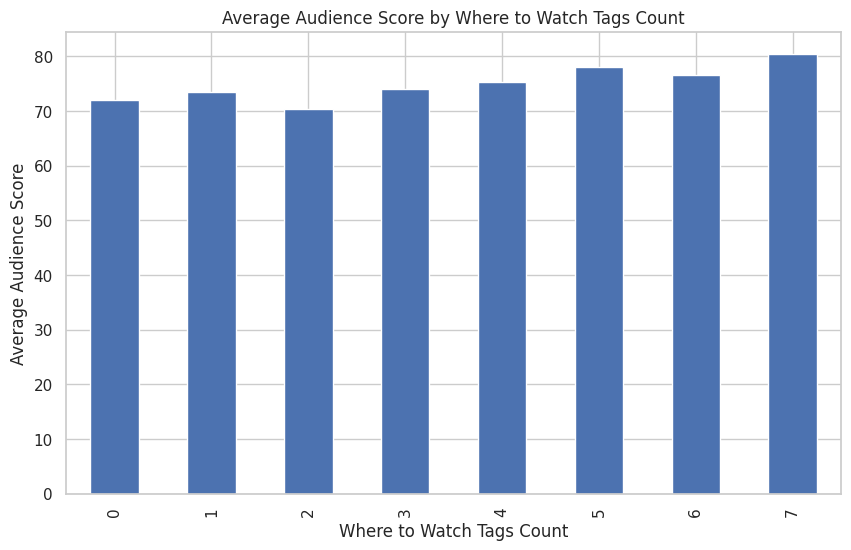

In [ ]:
average_score_by_tags = movies_final.groupby('Where to Watch Tags Count')['Audience Score'].mean()
average_score_by_tags.plot(kind='bar', figsize=(10, 6))
plt.title('Average Audience Score by Where to Watch Tags Count')
plt.xlabel('Where to Watch Tags Count')
plt.ylabel('Average Audience Score')
plt.show()

#### **Movie Synopses**

Movie synopses are brief summaries of a film's plot, providing potential viewers with a snapshot of the story, characters, setting, and tone without giving away crucial plot details or spoilers.

Synopses serve to inform, entice, and guide the audience, contributing to the viewer's movie selection process and setting expectations for the film experience.

We want to see if sentiment polarity for movie synopses is a valuable measure that could predict audience reception of a movie and its rating.

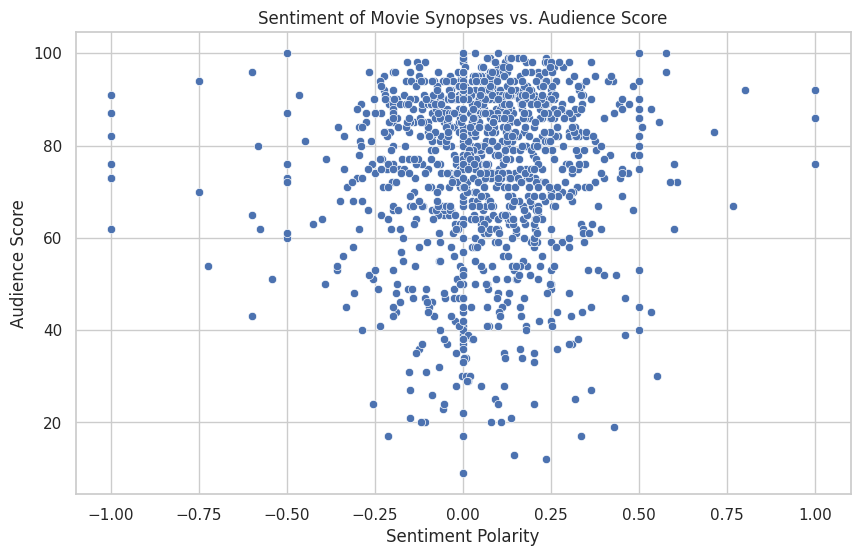

In [ ]:
from textblob import TextBlob

# Calculate sentiment polarity for each synopsis
movies_final['Sentiment'] = movies_final['Synopsis'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting sentiment against the Tomatometer Score
plt.figure(figsize=(10, 6))
sns.scatterplot(data=movies_final, x='Sentiment', y='Audience Score')
plt.title('Sentiment of Movie Synopses vs. Audience Score')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Audience Score')
plt.show()

The scatter plot depicting the relationship between the sentiment polarity of movie synopses and audience scores suggests the following:

1. Positive Sentiment Bias: The sentiment polarity of synopses mostly skews positive, indicating that synopses generally tend to highlight the appealing aspects of movies, which makes sense as these are meant to attract an audience.

2. Weak Relationship: There appears to be a weak relationship between the sentiment polarity of movie synopses and audience scores since scores are distributed randomly and lacking a direct relationship.

The plot indicates that while movie synopses generally aim to set a positive tone, the sentiment conveyed does not strongly predict how audiences will ultimately rate a movie. Similar to the movie availability analysis we did above, movie synopses is another feature that alone cannot determine or impact audience score.

###<font color=green> **Modeling** </font>

Now, having successfully processed and cleaned the movie dataset and visualized features, we can get into the **modeling** phase.

#### **Initial Model**

Our objective was to build a Random Forest Regressor model to predict the 'Tomatometer Score' of movies based on various features. We selected relevant features such as 'Genre,' 'Original Language,' 'Director,' 'Runtime,' and several review-related metrics. The data was encoded to ensure compatibility with the machine learning model, and then we split it into training and testing sets using the **`train_test_split`** function. The Random Forest Regressor model was employed with 100 estimators, and it was trained on the training set. Predictions were made on the test set, and the model's performance was assessed using the **Mean Squared Error (MSE)**. This metric provides a quantitative measure of the average squared difference between predicted and actual values which allowed us to see the accuracy of our predictive model.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


movies_final.dropna(subset=['Tomatometer Score'], inplace=True)

X = movies_final[['Genre', 'Original Language', 'Director', 'Runtime', 'Num of All Critics Reviews', 'Num of Top Critics Reviews', 'Num of Fresh Reviews', 'Num of Rotten Reviews', 'Where to Watch Tags Count']]
y = movies_final['Tomatometer Score']

X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 4.492263983050846


 **Model Evaluation**

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')


R-squared: 0.991715289678119


The **Mean Squared Error (MSE)** of 4.49 indicates a relatively low average squared difference between the predicted and actual 'Tomatometer Score' values. This suggests that the Random Forest Regressor model performed well in minimizing prediction errors.

The **R-squared** value of 0.99 is exceptionally high, indicating that the model explains approximately 99.13% of the variance in the target variable. In regression analysis, R-squared is a measure of how well the model fits the actual data points.

We visualized the model's predictions against the actual tomatometer scores using a scatter plot. There was a strong alignment between the predicted and actual values as the closer the points are to a diagonal line, the more accurate the predictions are.



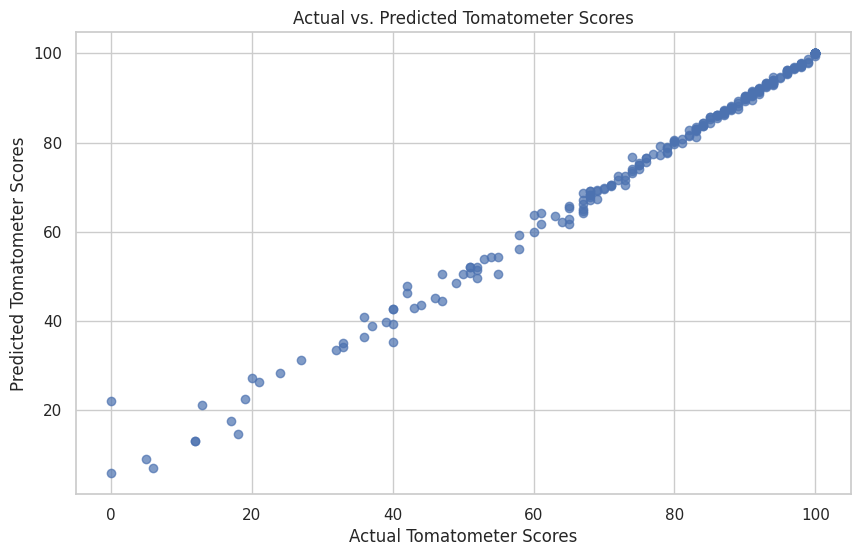

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title('Actual vs. Predicted Tomatometer Scores')
plt.xlabel('Actual Tomatometer Scores')
plt.ylabel('Predicted Tomatometer Scores')
plt.show()

#### **Modified Model**


The initial Random Forest Regressor model was built using various features, and its feature importances were analyzed. The top contributors to predicting the 'Tomatometer Score' were identified, with 'Num of Fresh Reviews' and 'Num of Rotten Reviews' having the highest importance, collectively accounting for a significant portion of the predictive power.

To explore the impact of excluding these dominant features, a modified model was created by removing 'Num of Fresh Reviews', 'Num of Rotten Reviews', and 'Num of All Critics Reviews'.

In [ ]:
# Get feature importances from the random forest model
importances = rf_model.feature_importances_

# Convert the importances into a DataFrame
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

# Sort the DataFrame to find the most important features
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

# Display the feature importances
print(feature_importances)


                                         feature  importance
2                           Num of Fresh Reviews    0.509055
3                          Num of Rotten Reviews    0.476777
0                     Num of All Critics Reviews    0.004924
1                     Num of Top Critics Reviews    0.001779
4                      Where to Watch Tags Count    0.001417
..                                           ...         ...
618                        Director_Martin Brest    0.000000
857                        Director_Shûkô Murase    0.000000
856  Director_Shoujirou Nishimi,Guillaume Renard    0.000000
855                       Director_Shinsuke Sato    0.000000
359                    Director_Gillo Pontecorvo    0.000000

[1108 rows x 2 columns]


In the second set, where 'Num of Fresh Reviews', 'Num of Rotten Reviews', and 'Num of All Critics Reviews' are excluded, the importance values are redistributed. 'Num of Top Critics Reviews' becomes the most influential feature (0.104), followed by other features such as 'Genre_Documentary', 'Where to Watch Tags Count', and 'Original Language_English'. The importance values of these features are higher compared to the remaining features in the first set, indicating their increased impact on the modified model's predictions.

In [ ]:
X_modified = X_encoded.drop(['Num of Fresh Reviews', 'Num of Rotten Reviews', 'Num of All Critics Reviews'], axis=1)
X_train_mod, X_test_mod, y_train_mod, y_test_mod = train_test_split(X_modified, y, test_size=0.2, random_state=42)
rf_model_mod = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_mod.fit(X_train_mod, y_train_mod)
importances_mod = rf_model_mod.feature_importances_
feature_importances_mod = pd.DataFrame({'feature': X_train_mod.columns, 'importance': importances_mod})
feature_importances_mod.sort_values(by='importance', ascending=False, inplace=True)
print(feature_importances_mod)


                          feature  importance
0      Num of Top Critics Reviews    0.103696
8               Genre_Documentary    0.056055
1       Where to Watch Tags Count    0.035389
29      Original Language_English    0.032873
989                Runtime_1h 30m    0.015257
..                            ...         ...
875        Director_Stephen Karam    0.000000
813      Director_S. Craig Zahler    0.000000
128         Director_Ayako Kawano    0.000000
874  Director_Stephen J. Anderson    0.000000
217    Director_Christopher Smith    0.000000

[1105 rows x 2 columns]


 **Model Evaluation**

The modified model achieved a high **R-squared value** of 0.9917, indicating a strong fit to the data, and a considerably lower **Mean Squared Error** of 506.66 compared to the original model.

In [ ]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test, y_pred)
print(f'R-squared Model 2 : {r2}')

R-squared Model 2 : 0.991715289678119


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

movies_final.dropna(subset=['Tomatometer Score'], inplace=True)

X = movies_final[['Genre', 'Original Language', 'Director', 'Runtime', 'Num of Top Critics Reviews', 'Where to Watch Tags Count']]
y = movies_final['Tomatometer Score']

X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 506.6556860169491


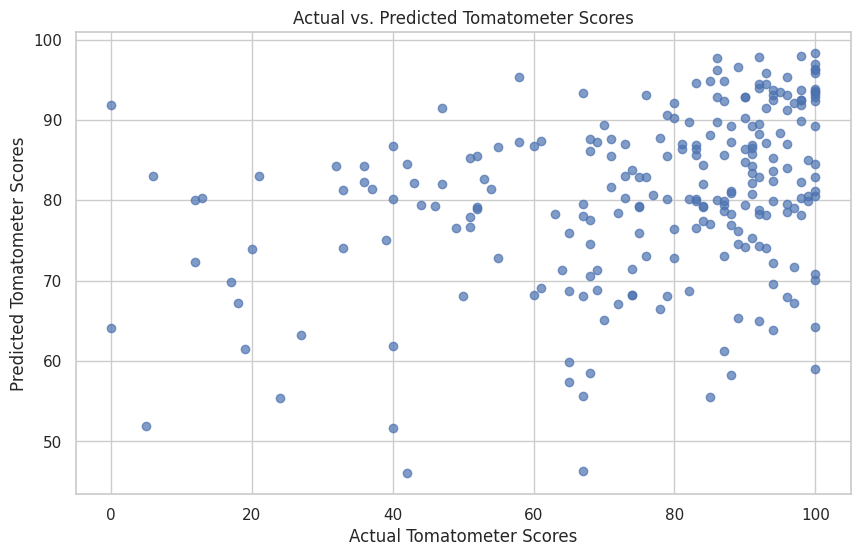

In [ ]:
import matplotlib.pyplot as plt

# Create a scatter plot of Actual vs. Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.title('Actual vs. Predicted Tomatometer Scores')
plt.xlabel('Actual Tomatometer Scores')
plt.ylabel('Predicted Tomatometer Scores')
plt.show()


The scatter plot of Actual vs. Predicted Tomatometer Scores reveals a less pronounced correlation between the true Tomatometer Scores and the scores predicted by the Random Forest Regressor model. In contrast to a perfect correlation where data points would align along a diagonal line, here, the points are more scattered. This indicates that the model's predictions are not as consistently aligned with the actual scores, suggesting a decrease in correlation strength.

It's essential to continually assess the different model's performance on different datasets and be aware of the potential for overfitting or underfitting. Also, techniques such as cross-validation and monitoring performance metrics on both the training and validation sets in the future can allow us to better understand whether the model strikes an appropriate balance or if further adjustments are needed.

###<font color=green> **Conclusion** </font>

**Our major findings throughout the project include:**

We learned how complex Movie Rating Predictions are, since predicting movie ratings is influenced beyond just the content of the movie. It involves understanding audience preferences, critical reception, cultural trends, and possibly even marketing efforts. During our EDA, we found common trends that might suggest good predictions, like the genre of the movie and explored the impact of critics.

Our modelling also reflected the feature importance of movies, including the Genre and Language Impact. Certain genres (like documentaries) and the original language of the movie (such as English) had a notable influence on the ratings.

Furthermore, we also learned about the Director Influence. While it was not highly influential in the model, the director's role in a film's success and its rating cannot be understated. Director's role has significant influence on the movie's direction and reception.

Therefore, we answered our main question, and investigated how movie ratings can be predicted with a high degree of accuracy using movie features such as genre and other relevant factors.

###<font color=green> **Further Investigation** </font>

1) **Feature Engineering:** Explore additional features or combinations of features that might have a stronger correlation with Tomatometer Scores. Feature scaling, normalization, or transformation could also be applied to enhance model performance.

2) **Text Analysis:** Use textual information like reviews or synopsis, natural language processing (NLP) techniques could be applied to extract sentiment or other relevant information that might influence ratings.

3) **External Factors:** Investigate if external factors, such as promotional campaigns, release dates, or critical events related to the movie industry, could impact Tomatometer Scores. Incorporating such factors might enhance the model's predictive power.